In [38]:
import pandas as pd
import numpy as np
from datetime import datetime
import plotly.express as px
import plotly.graph_objects as go
import re
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
from pmdarima.arima import auto_arima
from fbprophet import Prophet
from sklearn.model_selection import train_test_split

ModuleNotFoundError: No module named 'fbprophet'

In [3]:
data = pd.read_csv("./datasets/covid_19_data.csv", parse_dates=["ObservationDate", "Last Update"])
data

,SNo,ObservationDate,Province/State,Country/Region,Last Update,Confirmed,Deaths,Recovered
0,1,2020-01-22,Anhui,Mainland China,2020-01-22 17:00:00,1.0,0.0,0.0
1,2,2020-01-22,Beijing,Mainland China,2020-01-22 17:00:00,14.0,0.0,0.0
2,3,2020-01-22,Chongqing,Mainland China,2020-01-22 17:00:00,6.0,0.0,0.0
3,4,2020-01-22,Fujian,Mainland China,2020-01-22 17:00:00,1.0,0.0,0.0
4,5,2020-01-22,Gansu,Mainland China,2020-01-22 17:00:00,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...
306424,306425,2021-05-29,Zaporizhia Oblast,Ukraine,2021-05-30 04:20:55,102641.0,2335.0,95289.0
306425,306426,2021-05-29,Zeeland,Netherlands,2021-05-30 04:20:55,29147.0,245.0,0.0
306426,306427,2021-05-29,Zhejiang,Mainland China,2021-05-30 04:20:55,1364.0,1.0,1324.0
306427,306428,2021-05-29,Zhytomyr Oblast,Ukraine,2021-05-30 04:20:55,87550.0,1738.0,83790.0


In [4]:
data.dtypes

SNo                         int64
ObservationDate    datetime64[ns]
Province/State             object
Country/Region             object
Last Update        datetime64[ns]
Confirmed                 float64
Deaths                    float64
Recovered                 float64
dtype: object

In [5]:
def corrige_colunas(col_name):
    return re.sub(r"[/| ]", "", col_name).lower()

data.columns = [corrige_colunas(col) for col in data.columns]
data.head(2)

,sno,observationdate,provincestate,countryregion,lastupdate,confirmed,deaths,recovered
0,1,2020-01-22,Anhui,Mainland China,2020-01-22 17:00:00,1.0,0.0,0.0
1,2,2020-01-22,Beijing,Mainland China,2020-01-22 17:00:00,14.0,0.0,0.0


In [6]:
# filtrando os dados do Brasil para analise

brasil = data.loc[(data.countryregion == "Brazil") & (data.confirmed > 0)]
brasil.head(3)

,sno,observationdate,provincestate,countryregion,lastupdate,confirmed,deaths,recovered
2525,2526,2020-02-26,NaN,Brazil,2020-02-26 23:53:02,1.0,0.0,0.0
2631,2632,2020-02-27,NaN,Brazil,2020-02-26 23:53:02,1.0,0.0,0.0
2742,2743,2020-02-28,NaN,Brazil,2020-02-26 23:53:02,1.0,0.0,0.0


In [7]:
brasil.drop("provincestate", axis=1, inplace=True)

C:\Users\barretom\AppData\Local\Temp\ipykernel_5420\2634058691.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  brasil.drop("provincestate", axis=1, inplace=True)


In [8]:
brasil_group = brasil.groupby(by="observationdate", as_index=False).sum()
brasil_group

,observationdate,sno,confirmed,deaths,recovered
0,2020-02-26,2526,1.0,0.0,0.0
1,2020-02-27,2632,1.0,0.0,0.0
2,2020-02-28,2743,1.0,0.0,0.0
3,2020-02-29,2853,2.0,0.0,0.0
4,2020-03-01,2982,2.0,0.0,0.0
...,...,...,...,...,...
454,2021-05-25,8182819,16194209.0,452031.0,14231991.0
455,2021-05-26,8203474,16274695.0,454429.0,14272174.0
456,2021-05-27,8224129,16342162.0,456674.0,14455810.0
457,2021-05-28,8244784,16391930.0,459045.0,14492701.0


In [9]:
px.line(brasil_group, "observationdate", "confirmed", title="Evolução dos casos no Brasil")

In [10]:
brasil_group["novoscasos"] = list(map(
    lambda x: 0 if (x==0) else brasil_group["confirmed"].iloc[x] - brasil_group["confirmed"].iloc[x-1], np.arange(brasil_group.shape[0])))

In [11]:
px.line(brasil_group, x="observationdate", y="novoscasos", title="novos casos por dia")

In [18]:
fig = go.Figure()

fig.add_trace(
    go.Scatter(x=brasil_group.observationdate, y=brasil_group.deaths, name="Mortes",
               mode="lines+markers", line={"color": "red"})
)

fig.update_layout(title="Mortes por COVID-19 no Brasil")
fig.show()

In [19]:
def taxa_crescimento(data, variable, data_inicio=None, data_fim=None):
    if data_inicio == None:
        data_inicio = data.observationdate.loc[data[variable] > 0].min()
    else:
        data_inicio = pd.to_datetime(data_inicio)
        
    if data_fim == None:
        data_fim = data.observationdate.iloc[-1]
    else:
        data_fim = data.to_datetime(data_fim)
        
    passado = data.loc[data.observationdate == data_inicio, variable].values[0]
    presente = data.loc[data.observationdate == data_fim, variable].values[0]
    
    n = (data_fim - data_inicio).days
    
    taxa = (presente/passado)**(1/n) - 1
    
    return taxa * 100

In [20]:
taxa_crescimento(brasil_group, "confirmed")

3.694820710228286

In [21]:
def taxa_crescimento_diaria(data, variable, data_inicio=None):
    if data_inicio == None:
        data_inicio = data.observationdate.loc[data[variable] > 0].min()
    else:
        data_inicio = pd.to_datetime(data_inicio)
        
    data_fim = data.observationdate.max()
        
    n = (data_fim - data_inicio).days
    
    taxas = list(map(
        lambda x: (data[variable].iloc[x] - data[variable].iloc[x-1]) / data[variable].iloc[x-1],
        range(1, n+1)
    ))
    
    return np.array(taxas) * 100

In [22]:
tx_dia = taxa_crescimento_diaria(brasil_group, "confirmed")

px.line(x=pd.date_range(brasil_group.observationdate.min(), brasil_group.observationdate.max())[1:],
        y=tx_dia, title="Taxa de crescimento de casos confirmados no Brasil")

In [23]:
confirmados = brasil_group.confirmed
confirmados.index = brasil_group.observationdate
confirmados

observationdate
2020-02-26           1.0
2020-02-27           1.0
2020-02-28           1.0
2020-02-29           2.0
2020-03-01           2.0
                 ...    
2021-05-25    16194209.0
2021-05-26    16274695.0
2021-05-27    16342162.0
2021-05-28    16391930.0
2021-05-29    16471600.0
Name: confirmed, Length: 459, dtype: float64

In [24]:
res = seasonal_decompose(confirmados)

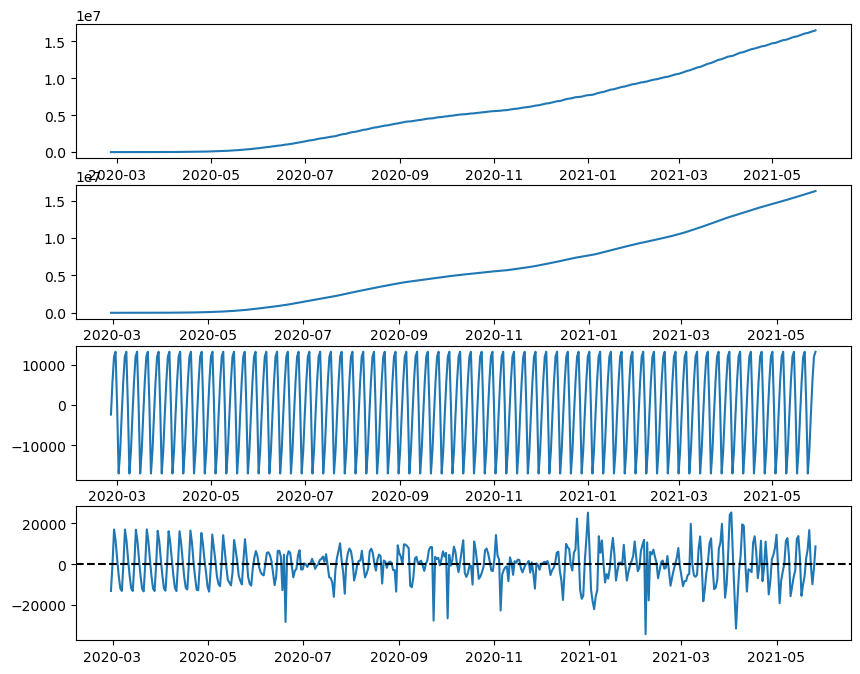

In [32]:
plt.figure(figsize=(10,8))
plt.subplot(411)
plt.plot(res.observed)
plt.subplot(412)
plt.plot(res.trend)
plt.subplot(413)
plt.plot(res.seasonal)
plt.subplot(414)
plt.plot(confirmados.index, res.resid)
plt.axhline(0, linestyle="dashed", c="black")

In [37]:
# Modelagem com ARIMA
modelo = auto_arima(confirmados)

fig = go.Figure(go.Scatter(
    x=confirmados.index, y=confirmados, name="Observados"
))
fig.add_trace(go.Scatter(
    x=confirmados.index, y=modelo.predict_in_sample(), name="Preditos"
))
fig.add_trace(go.Scatter(
    x=pd.date_range("2021-05-30", "2021-06-30"), y=modelo.predict(31), name="forecast"
))
fig.update_layout(title="Previsão de casos confirmados no Brasil para os próximos 30 dias")
fig.show()

In [ ]:
# Modelagem com Prophet

train = confirmados.reset_index()[:-5]
test = confirmados.reset_index()[-5:]

#renomeando colunas
train.rename(columns={"observationdate": "ds", "confirmed": "y"}, inplace=True)
test.rename(columns={"observationdate": "ds", "confirmed": "y"}, inplace=True)

# definindo modelo de crescimento
profeta = Prophet(growth="logistic", changepoints=["2020-03-21", "2020-03-30", "2020-04-25", "2020-05-03", "2020-05-10",
                                                   "2020-06-19", "2020-07-22", "2020-07-29", "2020-09-24", "2020-10-03",
                                                   "2020-10-16", "2020-11-06", "2020-11-11", "2020-12-16", "2021-01-07",
                                                   "2021-02-07", "2021-02-09", "2021-04-01", "2021-04-09"])

pop = 213993441
train["cap"] = pop

# treina o modelo
profeta.fit(train)

#contruir previsões para o futuro

future_dates = profeta.make_future_dataframe(periods=200)
future_dates["cap"] = pop
forecast = profeta.predict(future_dates)

In [ ]:
fig = go.Figure()

fig.add_trace(go.Scatter(x=forecast.ds, y=forecast.yhat, name="Predição"))
fig.add_trace(go.Scatter(x=test.index, y=test, name="Observados - Teste"))
fig.add_trace(go.Scatter(x=train.ds, y=train.y, name="Observados - Treino"))
fig.update_layout(title="Predições de casos confirmados no Brasil")

fig.show()